In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os

In [3]:
import inspect

In [4]:
sys.path.append("../scripts/")

In [5]:
import json
from copy import deepcopy

In [6]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [7]:
from datasets import Dataset as HuggingfaceDataset

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (10, 8)

In [9]:
from transformers import Seq2SeqTrainer

In [10]:
from sinusoidal_positional_embedding_new import SinusoidalPositionalEmbedding

In [11]:
from tqdm import tqdm
from collections import defaultdict
import torch
import transformers
from torch.nn import CrossEntropyLoss, MSELoss
from datasets import load_dataset, load_metric
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from dataset import (CitationTextGenerationDataset, 
                     CitationParagraphGenerationDatasetOld, 
                     CitationParagraphGenerationDataset,
                     CitationContextSpanSeparateDataset
                    )
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [13]:
import analysis_utils
from modelling_led_multitask import (
    LEDForConditionalGenerationAddContextLength as LEDForConditionalGeneration
)

In [14]:
device = "cuda"

In [15]:
max_input_length = 16384
max_output_length = 1024

In [16]:
def process_data_to_model_inputs(batch, special_tokens=None, length=None, classification=False):
    # tokenize the inputs and labels
    if special_tokens is None:
        special_tokens = ['[Dominant]', '[Reference]']
    
    additional_special_tokens_lookup = {token: idx for token, idx in zip(tokenizer.additional_special_tokens, tokenizer.additional_special_tokens_ids)}
    special_token_ids = set([additional_special_tokens_lookup[token] for token in special_tokens])
    special_token_ids.add(tokenizer.mask_token_id)
    
    inputs = tokenizer(
        batch["source"],
        padding="max_length",
        truncation=True,
        max_length=max_input_length,
        add_special_tokens=True 
    )
    outputs = tokenizer(
        batch["target"],
        padding="max_length",
        truncation=True,
        max_length=max_output_length,
        add_special_tokens=True 
    )
    if length:
        batch["length"] = length
    else:
        span_outputs = tokenizer(
            batch["span_target"],
            padding="max_length",
            truncation=True,
            max_length=max_output_length,
            add_special_tokens=True 
        )

        batch["length"] = [sum(x) for x in span_outputs.attention_mask]


    batch["input_ids"] = inputs.input_ids
    batch["attention_mask"] = inputs.attention_mask

    # create 0 global_attention_mask lists
    batch["global_attention_mask"] = len(batch["input_ids"]) * [
        [0 for _ in range(len(batch["input_ids"][0]))]
    ]

    # since above lists are references, the following line changes the 0 index for all samples
    for i_batch in range(len(batch["input_ids"])):
        for i_token in range(len(batch["input_ids"][0])):
            if batch["input_ids"][i_batch][i_token] in special_token_ids:
                batch["global_attention_mask"][i_batch][i_token] = 1
    
    # setting [CLS] token as global attention token for classification
    if classification:
        batch["global_attention_mask"][i_batch][0] = 1
            
    batch["labels"] = outputs.input_ids

    # We have to make sure that the PAD token is ignored
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in labels]
        for labels in batch["labels"]
    ]
    return batch

In [22]:
path = "/home/bxm200000/models/dominant_only/length_control/para_cdlm_v1_add_context_length_perturb/checkpoint-36500/"

In [23]:
tokenizer = AutoTokenizer.from_pretrained(path)
special_tokens = ['<doc>','</doc>', '[BOS]', '[Dominant]', '[Reference]', '[B_Dominant]',  '[E_Dominant]', '[B_Reference]', '[E_Reference]', '<context>', '</context>']
additional_special_tokens = {'additional_special_tokens': special_tokens}
tokenizer.add_special_tokens(additional_special_tokens)

0

In [24]:
model = LEDForConditionalGeneration.from_pretrained(
    path
)

In [25]:
model = model.to(device).half()

In [26]:
model.config.add_perturbation

True

In [27]:
# model.led.decoder.embed_positions.sinpostype = None
# model.config.sinpostype = None
model.eval()

LEDForConditionalGenerationAddContextLength(
  (led): LEDModel(
    (shared): Embedding(50276, 768, padding_idx=1)
    (encoder): LEDEncoder(
      (embed_tokens): Embedding(50276, 768, padding_idx=1)
      (embed_positions): LEDLearnedPositionalEmbedding(16384, 768, padding_idx=1)
      (layers): ModuleList(
        (0): LEDEncoderLayer(
          (self_attn): LEDEncoderAttention(
            (longformer_self_attn): LEDEncoderSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (query_global): Linear(in_features=768, out_features=768, bias=True)
              (key_global): Linear(in_features=768, out_features=768, bias=True)
              (value_global): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): Linear(in_features=768, out_features=768, bia

In [28]:
val_set = CitationParagraphGenerationDataset(
    "/home/data/XiangciLi/CORWA/annotated_test/", 
    tokenizer, 
    MAX_SENT_LEN = max_input_length,
    related_work_path='/home/data/XiangciLi/20200705v1/acl/selected_related_work.jsonl',
    cited_metadata_path='/home/data/XiangciLi/20200705v1/acl/selected_cited_metadata.jsonl',
    cited_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_cited_pdf_parses.jsonl",
    citing_paper_path="/home/data/XiangciLi/20200705v1/acl/selected_pdf_parses.jsonl",
    skip_no_citations = True,context_sep_flag=True,
    include_intro=False,
    add_length_signal=True
)

100%|██████████| 362/362 [00:12<00:00, 29.61it/s]


In [29]:
val_set.filter_citation_type(citation_type="Dominant")

In [36]:
def get_citations(src):
    """Get citations given source content"""
    all_citations = []
    for cite_data in src.split("[B_Reference]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())

    for cite_data in src.split("[B_Dominant]")[1:]:

        all_citations.append(cite_data.split("</s>")[0].strip())
    
    return all_citations

In [ ]:
# accumulated_data = []
for batch in tqdm(DataLoader(val_set[124:], batch_size = 1, shuffle=False)):
    processed_batch = process_data_to_model_inputs(
        batch, 
        special_tokens=['[Dominant]', '[Reference]'], 
        classification=True
    )
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels", "length", "context_length"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    model_kwargs = {'decoder_context_length' : processed_batch_cuda["context_length"]}
    predicted_abstract_ids = model.generate(
        input_ids = processed_batch_cuda["input_ids"], 
        attention_mask=processed_batch_cuda["attention_mask"], 
        global_attention_mask=processed_batch_cuda["global_attention_mask"],
        **model_kwargs
    )
    out = tokenizer.batch_decode(predicted_abstract_ids, skip_special_tokens=False)
    target = batch["target"]
    for o, t, part_id, source in zip(out, target, batch["id"], batch["source"]):
        accumulated_data.append(
            {"source": source, "target": t, 
             "generated": o, "part_id": part_id}
        )

  0%|          | 0/1198 [00:00<?, ?it/s]/home/bxm200000/anaconda3/envs/tagger_4/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  # Remove the CWD from sys.path while we load stuff.
/home/bxm200000/anaconda3/envs/tagger_4/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
 96%|█████████▌| 1146/1198 [15:52:09<40:51, 47.15s/it]   

In [54]:
len(accumulated_data)

1322

In [39]:
# diffs = []

# for dt in accumulated_data:
#     diffs.append(tokenizer.tokenize(dt["target"]).__len__() - tokenizer.tokenize(dt["generated"]).__len__() )

In [40]:
# plt.hist(diffs)

In [55]:
def get_val(tensor):
    return tensor.cpu().detach().numpy().item()

In [126]:
# LENGTH PREDICTION
length_data = []
for batch in tqdm(DataLoader(val_set, batch_size = 1, shuffle=False)):
    processed_batch = process_data_to_model_inputs(
        batch, 
        special_tokens=None, 
        classification=True
    )
    processed_batch_cuda = {}
    for key in ["input_ids", "attention_mask", "global_attention_mask", "labels", "length"]:
        processed_batch_cuda[key] = torch.tensor(processed_batch[key]).to(device)
    model_kwargs = {'decoder_length' : processed_batch_cuda["length"].unsqueeze(0)}

    
    cls_encoder = model.led.encoder(
        input_ids=processed_batch_cuda["input_ids"],
        attention_mask=processed_batch_cuda["attention_mask"],
        global_attention_mask=processed_batch_cuda["global_attention_mask"],
        return_dict=True
    )[0][:,0,:]
    
    if model.config.predict_log_length:
        length_pred = torch.exp(model.lm_length(cls_encoder))
    else:
        length_pred = model.lm_length(cls_encoder)
    length_pred = length_pred.squeeze(-1)    
    
    for l_pred, l_actual in zip(length_pred, processed_batch_cuda["length"]):
        length_data.append( (get_val(l_pred), get_val(l_actual)) )
        
    
#     for l_pred, l_actual in zip(length_pred, processed_batch_cuda["length"]):
#         length_data.append( (get_val(l_pred), get_val(l_actual)) )
    

100%|██████████| 1322/1322 [12:43<00:00,  1.73it/s]


In [57]:
# len(length_data)

### Save Length predictions

In [40]:
store_len_data = []
for dt, l in zip(val_set, length_data):

    store_len_data.append({"id": dt["id"], "length": (float(l[0]), float(l[1])) })

In [155]:
# with open(os.path.abspath(os.path.join(path, "../length_output.json")), 'w') as f:
#     json.dump(store_len_data, f)

### Load Length Predictions

In [166]:
with open(os.path.abspath(os.path.join(path, "../length_output.json")), 'r') as f:
    store_len_data = json.loads(f.read())
length_data = [(*x["length"], ) for x in store_len_data]

### Save Generations

In [59]:
# accumulated_data[0]

In [60]:
sep_tokens = ["<s>", "</s>"]
for index, data in enumerate(accumulated_data):
    for token in sep_tokens:
        data["generated"] = data["generated"].replace(token, "").strip() 

In [62]:
with open(os.path.abspath(os.path.join(path, "../sample_para_output.json")), 'w') as f:
    json.dump(accumulated_data, f)

### Load generations

In [170]:
with open(os.path.abspath(os.path.join(path, "../sample_para_output.json")), 'r') as f:
    accumulated_data = json.loads(f.read())

In [171]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

In [172]:
length_predictions = np.array(list(zip(*length_data))[0])
lenthg_targets = np.array(list(zip(*length_data))[1])

In [173]:
# length_predictions

### Generated vs Target length

In [177]:
good_datapoints = analysis_utils.get_valid_paragraph_datapoints(accumulated_data)

In [199]:
len(accumulated_data)

1322

In [178]:
lenthg_targets = np.array([tokenizer.tokenize(x["target"]).__len__() for x in good_datapoints])

In [179]:
length_generations = np.array([tokenizer.tokenize(x["generated"]).__len__() for x in good_datapoints])

In [180]:
np.mean(abs( lenthg_targets - length_generations))

15.9415337889142

In [195]:
np.mean( lenthg_targets - length_generations)

-2.305998481397115

In [182]:
rmse(lenthg_targets, length_generations )

21.84516161077924

Text(0.5, 1.0, 'Target length - Generation Length - Paragraph generation LC')

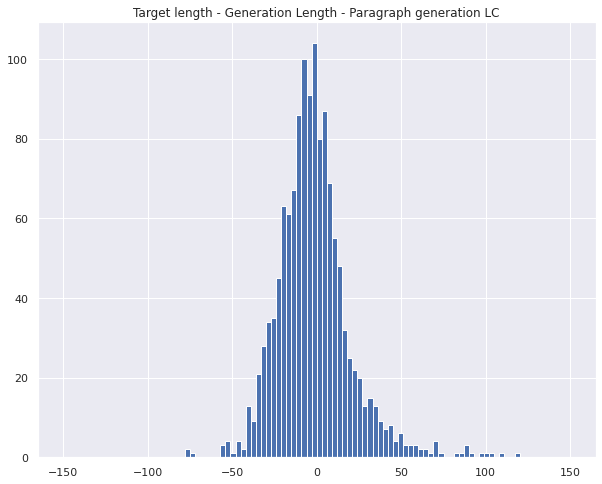

In [200]:
plt.hist(lenthg_targets - length_generations, bins=100, range = (-150, 150))
plt.title("Target length - Generation Length - Paragraph generation LC")

### Generation vs Predicted Length

### Post-Process paragraph Generation - extract spans

In [63]:
def strip_context(paragraph):
    """strip context from paragraph and only return span"""
    return paragraph.split("<context>")[1].split("</context>")[0].strip()

In [64]:
# accumulated_data[0]

In [65]:
new_accumulated_data = deepcopy(accumulated_data)

In [66]:
rouge = load_metric("rouge")

In [67]:
predicted, references = [], []
dominant_predicted, dominant_reference = [], []
reference_predicted, reference_reference = [], []
for index, data in enumerate(new_accumulated_data):
    target = data["target"]
    gen = data["generated"]
    
    
    if "<context>" in gen and "</context>" in gen:

        target = strip_context(data["target"])
        gen = strip_context(data["generated"])
        data["generated"] = gen
        data["target"] = target

        new_accumulated_data[index] = data
        # remove citations         
        for c in get_citations(data["source"]):
            c = c.replace(",", "").replace(".", "")
            gen = gen.replace(",", "").replace(".", "").replace(c, "")
            target = target.replace(",", "").replace(".", "").replace(c, "")

        predicted.append(gen)
        references.append(target)

        if "[Dominant]" in data["source"]:
            dominant_predicted.append(gen)
            dominant_reference.append(target)


        if "[Reference]" in data["source"]:
            reference_predicted.append(gen)
            reference_reference.append(target)


In [68]:
# dominant_predicted

In [69]:
len(dominant_predicted)

1317

In [70]:
rouge.compute(
    predictions=predicted, 
    references=references, 
    rouge_types=["rouge1","rouge2","rougeL"],           
    use_stemmer=True
)

{'rouge1': AggregateScore(low=Score(precision=0.252551821542718, recall=0.26237485657003834, fmeasure=0.23625074011341463), mid=Score(precision=0.2603201468414728, recall=0.27014311922942136, fmeasure=0.24255346907640699), high=Score(precision=0.2687455075158768, recall=0.2780549912317007, fmeasure=0.24889547415893087)),
 'rouge2': AggregateScore(low=Score(precision=0.05404289084709848, recall=0.05761130475788302, fmeasure=0.05089834534993279), mid=Score(precision=0.05937584493041693, recall=0.062283362650859805, fmeasure=0.055127268685939146), high=Score(precision=0.06396616794563971, recall=0.067196774794971, fmeasure=0.059183562033996384)),
 'rougeL': AggregateScore(low=Score(precision=0.19166101346981235, recall=0.2009076742426963, fmeasure=0.1797225313079823), mid=Score(precision=0.19817983182594884, recall=0.20730878197066505, fmeasure=0.18501425713017183), high=Score(precision=0.20465630695008863, recall=0.21403363459838645, fmeasure=0.1896533675600201))}